In [1]:
from __future__ import print_function
import os.path
import dalmatian as dm
import pandas as pd
import sys
from CCLE_postp_function import *
sys.path.insert(0, '../JKBio/')
import Datanalytics as da 
import TerraFunction as terra
from Helper import * 
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
from IPython.display import Image,display
from taigapy import TaigaClient
tc = TaigaClient()
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
from collections import OrderedDict

ModuleNotFoundError: No module named 'dalmatian'

In [2]:
namespace1="broad-genomics-delivery"
workspace1="Getz_IBM_CellLines_RNASeqData"
namespace2="broad-firecloud-ccle"
workspace2="CCLE_DepMap_RNAseq"
namespace3="broad-genomics-delivery"
workspace3="CCLE_DepMap_RNAseq"
namespace4="broad-genomics-delivery"
workspace4="Cancer_Cell_Line_Factory_CCLF_RNAseq"
namespace5="nci-mimoun-bi-org"
workspace5="CCLF_RNA_2_0"
refnamespace="broad-firecloud-ccle"
refworkspace="DepMap_hg38_RNAseq"
source1="ibm"
source2="ccle"
source3="ccle"
source4="cclf"
samplesetname="19Q3"
release = samplesetname

In [4]:
wm1 = dm.WorkspaceManager(namespace1, workspace1)
wm2 = dm.WorkspaceManager(namespace2, workspace2)
wm3 = dm.WorkspaceManager(namespace3, workspace3)
wm4 = dm.WorkspaceManager(namespace4, workspace4)

refwm = dm.WorkspaceManager(refnamespace, refworkspace)

In [ ]:
## made some changes; now most all TerraFunction functions take a string of "namespace/workspace" 
## instead of the workspace manager object
## addToSampleSet, addToPairSet, updateAllSampleSet, waitForSubmission...

name_work1 = namespace1 + '/' + workspace1
name_work2 = namespace2 + '/' + workspace2
name_work3 = namespace3 + '/' + workspace3
name_work4 = namespace4 + '/' + workspace4
refname_work = refnamespace + '/' + refworkspace

# Generate sample set from new samples

In [8]:
newsamples = createDatasetWithNewCellLines(refwm, samplesetname, wm1, source1,
wm2, source2,
wm3, source3,
wm4, source4)

/Users/jeremie/Documents/Projects/BroadInstitute/ccle_processing/CCLE_postp_function.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (samples1['individual_alias'].str.slice(0, 10).isin(forcekeep))]


uploading new samples
Successfully imported 1388 participants.
Updating many hound records. Switching to batch updates
Hound executing batch upload of 2 records
Successfully imported 1402 samples.
Updating many hound records. Switching to batch updates
Hound executing batch upload of 109358 records
creating a sample set
Successfully imported 1 sample sets:
  * 19Q3add (1 samples)


# run the pipeline

In [9]:
samtofastq = refwm.get_config("samtofastq_v1-0_BETA_cfg")
samtofastq

{'deleted': False,
 'inputs': {'samtofastq_workflow.samtofastq.prefix': 'this.name',
  'samtofastq_workflow.samtofastq.disk_space': '100',
  'samtofastq_workflow.samtofastq.num_threads': '1',
  'samtofastq_workflow.samtofastq.memory': '8',
  'samtofastq_workflow.samtofastq.num_preempt': '5',
  'samtofastq_workflow.samtofastq.input_bam_cram': 'this.WES_bam'},
 'methodConfigVersion': 4,
 'methodRepoMethod': {'methodName': 'samtofastq_v1-0_BETA',
  'methodVersion': 5,
  'methodNamespace': 'broadinstitute_gtex',
  'methodUri': 'agora://broadinstitute_gtex/samtofastq_v1-0_BETA/5',
  'sourceRepo': 'agora'},
 'name': 'samtofastq_v1-0_BETA_cfg',
 'namespace': 'broadinstitute_gtex',
 'outputs': {'samtofastq_workflow.samtofastq.fastq1': 'this.fastq1',
  'samtofastq_workflow.samtofastq.fastq2': 'this.fastq2'},
 'prerequisites': {},
 'rootEntityType': 'sample'}

In [10]:
samtofastq['samtofastq_workflow.samtofastq.input_bam_cram']= 'this.WES_bam'
refwm.update_config(samtofastq)
submission_id = refwm.create_submission(samtofastq['name'], samplesetname,'sample_set',expression='this.samples')

Successfully updated configuration broadinstitute_gtex/samtofastq_v1-0_BETA_cfg


ValueError: Expression evaluates to 0 entities

In [24]:
terra.waitForSubmission(refname_work, submission_id)

Traceback (most recent call last):
  File "/anaconda3/envs/py36/lib/python3.6/site-packages/hound/client.py", line 60, in _bulk_upload
    assert proc.returncode == 0
AssertionError
/anaconda3/envs/py36/lib/python3.6/site-packages/hound/client.py:63: UserWarning: Fast record population failed. Switching to slower fallback
  warnings.warn("Fast record population failed. Switching to slower fallback")


ibm_ACH-001525led for 0 jobs in submission 0. 2 mn elapsed.
ibm_ACH-001690
0.8 of jobs Succeeded in submission 0.sion 0. 22 mn elapsed.


['ibm_ACH-001525', 'ibm_ACH-001690']

In [25]:
star = refwm.get_config("star_v1-0_BETA_cfg")
star

{'deleted': False,
 'inputs': {'star_workflow.star.outSAMattrRGline': '"ID:rg1 SM:sm1"',
  'star_workflow.star.num_threads': '8',
  'star_workflow.star.alignSoftClipAtReferenceEnds': '"Yes"',
  'star_workflow.star.alignMatesGapMax': '1000000',
  'star_workflow.star.outFilterType': '"BySJout"',
  'star_workflow.star.prefix': 'this.name',
  'star_workflow.star.num_preempt': '5',
  'star_workflow.star.alignSJoverhangMin': '8',
  'star_workflow.star.chimOutJunctionFormat': '1',
  'star_workflow.star.memory': '52',
  'star_workflow.star.fastq2': 'this.fastq2',
  'star_workflow.star.outFilterMismatchNoverLmax': '0.1',
  'star_workflow.star.alignIntronMax': '1000000',
  'star_workflow.star.star_index': 'workspace.star_index',
  'star_workflow.star.outSAMattributes': '"NH HI AS nM NM ch"',
  'star_workflow.star.outSAMstrandField': '"intronMotif"',
  'star_workflow.star.limitSjdbInsertNsj': '1200000',
  'star_workflow.star.chimSegmentMin': '15',
  'star_workflow.star.chimJunctionOverhangMin': '

In [26]:
refwm.update_config(star)
submission_id = refwm.create_submission(star['name'], samplesetname,'sample_set',expression='this.samples')

Successfully updated configuration broadinstitute_gtex/star_v1-0_BETA_cfg
Successfully created submission 74abf225-3d6f-4d34-bcbe-42bdeaccbe30.


In [ ]:
rnasnps = refwm.get_config("rnaseq-germline-snps-indels")
rnasnps

In [ ]:
refwm.update_config(rnasnps)
submission_id_snp = refwm.create_submission(rnasnps['name'], samplesetname,'sample_set',expression='this.samples')

In [28]:
terra.waitForSubmission(refname_work, submission_id)

1.0 of jobs Succeeded in submission 0.sion 0. 19 mn elapsed.


[]

In [29]:
rsem = refwm.get_config("rsem_v1-0_BETA_cfg")
rsem

{'deleted': False,
 'inputs': {'rsem_workflow.rsem.transcriptome_bam': 'this.star_transcriptome_bam',
  'rsem_workflow.rsem.max_frag_len': '1000',
  'rsem_workflow.rsem.memory': '50',
  'rsem_workflow.rsem.prefix': 'this.name',
  'rsem_workflow.rsem.disk_space': '100',
  'rsem_workflow.rsem.estimate_rspd': '"true"',
  'rsem_workflow.rsem.is_stranded': '"false"',
  'rsem_workflow.rsem.rsem_reference': 'workspace.rsem_reference',
  'rsem_workflow.rsem.num_preempt': '5',
  'rsem_workflow.rsem.num_threads': '2'},
 'methodConfigVersion': 5,
 'methodRepoMethod': {'methodName': 'rsem_v1-0_BETA',
  'methodVersion': 4,
  'methodNamespace': 'broadinstitute_gtex',
  'methodUri': 'agora://broadinstitute_gtex/rsem_v1-0_BETA/4',
  'sourceRepo': 'agora'},
 'name': 'rsem_v1-0_BETA_cfg',
 'namespace': 'broadinstitute_gtex',
 'outputs': {'rsem_workflow.rsem.genes': 'this.rsem_genes',
  'rsem_workflow.rsem.isoforms': 'this.rsem_isoforms'},
 'prerequisites': {},
 'rootEntityType': 'sample'}

In [30]:
refwm.update_config(rsem)
submission_id1 = refwm.create_submission(rsem['name'], samplesetname,'sample_set',expression='this.samples')

Successfully updated configuration broadinstitute_gtex/rsem_v1-0_BETA_cfg
Successfully created submission 39a4b936-8772-49ce-93f8-482b4d18b0bd.


In [33]:
terra.waitForSubmission(refname_work, submission_id1)

1.0 of jobs Succeeded in submission 0.


[]

In [34]:
fusion = refwm.get_config("hg38_STAR_fusion")
fusion

{'deleted': False,
 'inputs': {'trinity_cleaned.StarFusion.ref_genome_fa_star_idx_files': 'workspace.hg38_star_fusion_ctat_star_index_files',
  'trinity_cleaned.samtofastq.num_preempt': '4',
  'trinity_cleaned.StarFusion.memory': '64',
  'trinity_cleaned.remove_intermediate_files': 'true',
  'trinity_cleaned.StarFusion.num_preempt': '2',
  'trinity_cleaned.StarFusion.ctat_genome_lib_build_dir_files': 'workspace.hg38_star_fusion_ctat_files',
  'trinity_cleaned.prefix': 'this.name',
  'trinity_cleaned.StarFusion.num_threads': '8',
  'trinity_cleaned.samtofastq.memory': '16',
  'trinity_cleaned.samtofastq.num_threads': '1',
  'trinity_cleaned.samtofastq.input_bam': 'this.WES_bam',
  'trinity_cleaned.StarFusion.disk_space': '500',
  'trinity_cleaned.StarFusion.docker': '"trinityctat/ctatfusion:1.6.0"',
  'trinity_cleaned.samtofastq.disk_space': '100'},
 'methodConfigVersion': 8,
 'methodRepoMethod': {'methodName': 'STAR_fusion',
  'methodVersion': 14,
  'methodNamespace': 'gkugener',
  'me

In [35]:
fusion['inputs']['trinity_cleaned.samtofastq.input_bam'] = 'this.WES_bam'
refwm.update_config(fusion)
submission_id2 = refwm.create_submission(fusion['name'], samplesetname,'sample_set',expression='this.samples')

Successfully updated configuration gkugener/hg38_STAR_fusion
Successfully created submission 82f53a64-3dc3-40bd-af81-def43059b7a0.


In [ ]:
aggregate = refwm.get_config("rsem_aggregate_results_v1-0_BETA_cfg")
aggregate

In [50]:
updateAllSampleSet('CCLE_'+samplesetname, Allsample_setname='DM19Q2_PATHS_CORRECTED_V2')

In [57]:
submission_id1 = refwm.create_submission(aggregate['name'], 'All_samples')

Successfully created submission 2840c346-6310-4bbb-ad3b-053f6692d4d7.


## Expression post processing

In [58]:
terra.wait_for_submission(refname_work, [submission_id1, submission_id_snp, submission_id2])

NameError: name 'wait_for_submission' is not defined

In [4]:
%%R
release <- '19Q3'

In [5]:
%%R
library('taigr')

2019-07-23 04:30:33::WARNING  R[write to console]: Le chargement a nécessité le package : RCurl

2019-07-23 04:30:33::WARNING  R[write to console]: Le chargement a nécessité le package : bitops

2019-07-23 04:30:33::WARNING  R[write to console]: Le chargement a nécessité le package : httr



In [6]:
%%R
source('../JKBio/gkugener/RScripts/load_libraries_and_annotations.R')

2019-07-23 04:30:35::WARNING  R[write to console]: 
Attachement du package : ‘dplyr’


2019-07-23 04:30:35::WARNING  R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


2019-07-23 04:30:35::WARNING  R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


2019-07-23 04:30:35::WARNING  R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


2019-07-23 04:30:36::WARNING  R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

2019-07-23 04:30:36::WARNING  R[write to console]: ✔ ggplot2 3.2.0     ✔ readr   1.3.1
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ ggplot2 3.2.0     ✔ forcats 0.4.0

2019-07-23 04:30:36::WARNING  R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_confl

2019-07-23 04:30:37::WARNING  R[write to console]: Le chargement a nécessité le package : S4Vectors

2019-07-23 04:30:38::WARNING  R[write to console]: 
Attachement du package : ‘S4Vectors’


2019-07-23 04:30:38::WARNING  R[write to console]: The following objects are masked from ‘package:data.table’:

    first, second


2019-07-23 04:30:38::WARNING  R[write to console]: The following object is masked from ‘package:plotly’:

    rename


2019-07-23 04:30:38::WARNING  R[write to console]: The following object is masked from ‘package:tidyr’:

    expand


2019-07-23 04:30:38::WARNING  R[write to console]: The following objects are masked from ‘package:dplyr’:

    first, rename


2019-07-23 04:30:38::WARNING  R[write to console]: The following object is masked from ‘package:plyr’:

    rename


2019-07-23 04:30:38::WARNING  R[write to console]: The following object is masked from ‘package:base’:

    expand.grid


2019-07-23 04:30:38::WARNING  R[write to console]: Le chargement a nécess

In [7]:
%%R
source('CCLE_postp_function.R')

2019-07-23 04:30:40::WARNING  R[write to console]: 



In [14]:
res = refwm.get_sample_sets().loc['all_samples']
res

fusions_star                                                                     NaN
mergedExonUsageRObj_hg38                                                         NaN
rsem_genes_expected_count                                                        NaN
rsem_genes_tpm                                                                   NaN
rsem_transcripts_expected_count                                                  NaN
rsem_transcripts_isopct                                                          NaN
rsem_transcripts_tpm                                                             NaN
samples                            [dm_ACH-000001, dm_ACH-000002, dm_ACH-000003, ...
Name: all_samples, dtype: object

In [11]:
res = refwm.get_sample_sets().loc['All_samples']
rsem_genes_expected_count = res['rsem_genes_expected_count']
rsem_genes_tpm = res['rsem_genes_tpm']
rsem_transcripts_tpm = res['rsem_transcripts_tpm']
! gsutil cp $rsem_genes_expected_count "temp/" & gsutil cp $rsem_genes_tpm "temp/" & gsutil cp $rsem_transcripts_tpm "temp/"

NameError: name 'refwm' is not defined

In [12]:
%%R
# alternative one
download_paths <- list(
  counts_genes='temp/DM19Q2_PATHS_CORRECTED_V2.rsem_genes_expected_count.txt.gz',
  tpm_genes='temp/DM19Q2_PATHS_CORRECTED_V2.rsem_genes_tpm.txt.gz',
  tpm_transcripts='temp/DM19Q2_PATHS_CORRECTED_V2.rsem_transcripts_tpm.txt.gz')

In [9]:
%%R
# These files are downloaded from FireCloud/Terra
download_paths <- list(
  tpm_genes='temp/expression.genes.tpm.txt.gz',
  tpm_transcripts='temp/expression.transcript.tpm.txt.gz',
  counts_genes='temp/expression.expectedcount.txt.gz')

In [13]:
%%R
tpm_transcripts = readTranscripts(download_paths$tpm_transcripts)
counts_genes = readCounts(download_paths$counts_genes)
tpm_genes = readTPM(download_paths$tpm_genes)

2019-07-23 04:32:56::WARNING  R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  transcript_id = col_character(),
  gene_id = col_character()
)

2019-07-23 04:32:56::WARNING  R[write to console]: See spec(...) for full column specifications.

2019-07-23 04:33:56::WARNING  R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character(),
  `transcript_id(s)` = col_character()
)

2019-07-23 04:33:56::WARNING  R[write to console]: See spec(...) for full column specifications.

2019-07-23 04:34:18::WARNING  R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character(),
  `transcript_id(s)` = col_character()
)

2019-07-23 04:34:18::WARNING  R[write to console]: See spec(...) for full column specifications.



In [15]:
%%R
# Fix the colnames (for cases where there are mixed values (CCLE_name and DepMap_IDs))
colnames(counts_genes) %<>% renameFunction(.)
colnames(tpm_genes) %<>% renameFunction(.)
colnames(tpm_transcripts) %<>% renameFunction(.)

### data exploration and QC

In [19]:
%%R
tpm_genes[,'ACH-001767']

# A tibble: 58,813 x 1
   `ACH-001767`
          <dbl>
 1         1.22
 2         0   
 3         5.51
 4         0.87
 5         0.16
 6         0   
 7         2.86
 8         2.79
 9         6.02
10         1.04
# … with 58,803 more rows


In [11]:
%%R 
# Quick QC
# We are looking for samples with a worrying amount of zeros
zero_threshold <- 39000
number_zeros <- apply(tpm_genes[,3:ncol(tpm_genes)], 2, FUN = function(x) length(x[x == 0]))
nzdf <- data.frame(CL=names(number_zeros), nz=number_zeros, stringsAsFactors = F)

In [12]:
%%R
number_zeros <- number_zeros[order(-number_zeros)]
number_zeros <- number_zeros[number_zeros < zero_threshold]
pass <- number_zeros %>% names()

# These samples failed
failed <- setdiff(colnames(tpm_genes), pass) %>% .[!(. %in% c('gene_id', 'transcript_id(s)'))]

counts_genes %<>% dplyr::select(c("gene_id","transcript_id(s)", pass))
tpm_genes %<>% dplyr::select(c("gene_id","transcript_id(s)", pass))
tpm_transcripts %<>% dplyr::select(c("transcript_id", "gene_id", pass))

In [13]:
%%R
failed

[1] "ACH-001767"


In [ ]:
%%R 

In [14]:
%%R
# Plot of the samples that fail
plot <- ggplot(nzdf, aes(nz)) +
  geom_histogram(bins = 100, color='black', fill='white') +
  geom_vline(xintercept = zero_threshold, linetype=2) +
  geom_label_repel(data = nzdf %>% filter(nz > zero_threshold), aes(x=nz, y=0, label=CL), size=5, fill=rgb(1,1,1,0.5))

ggsave(plot, filename ='temp/ggplot.png', width=20, height = 20)

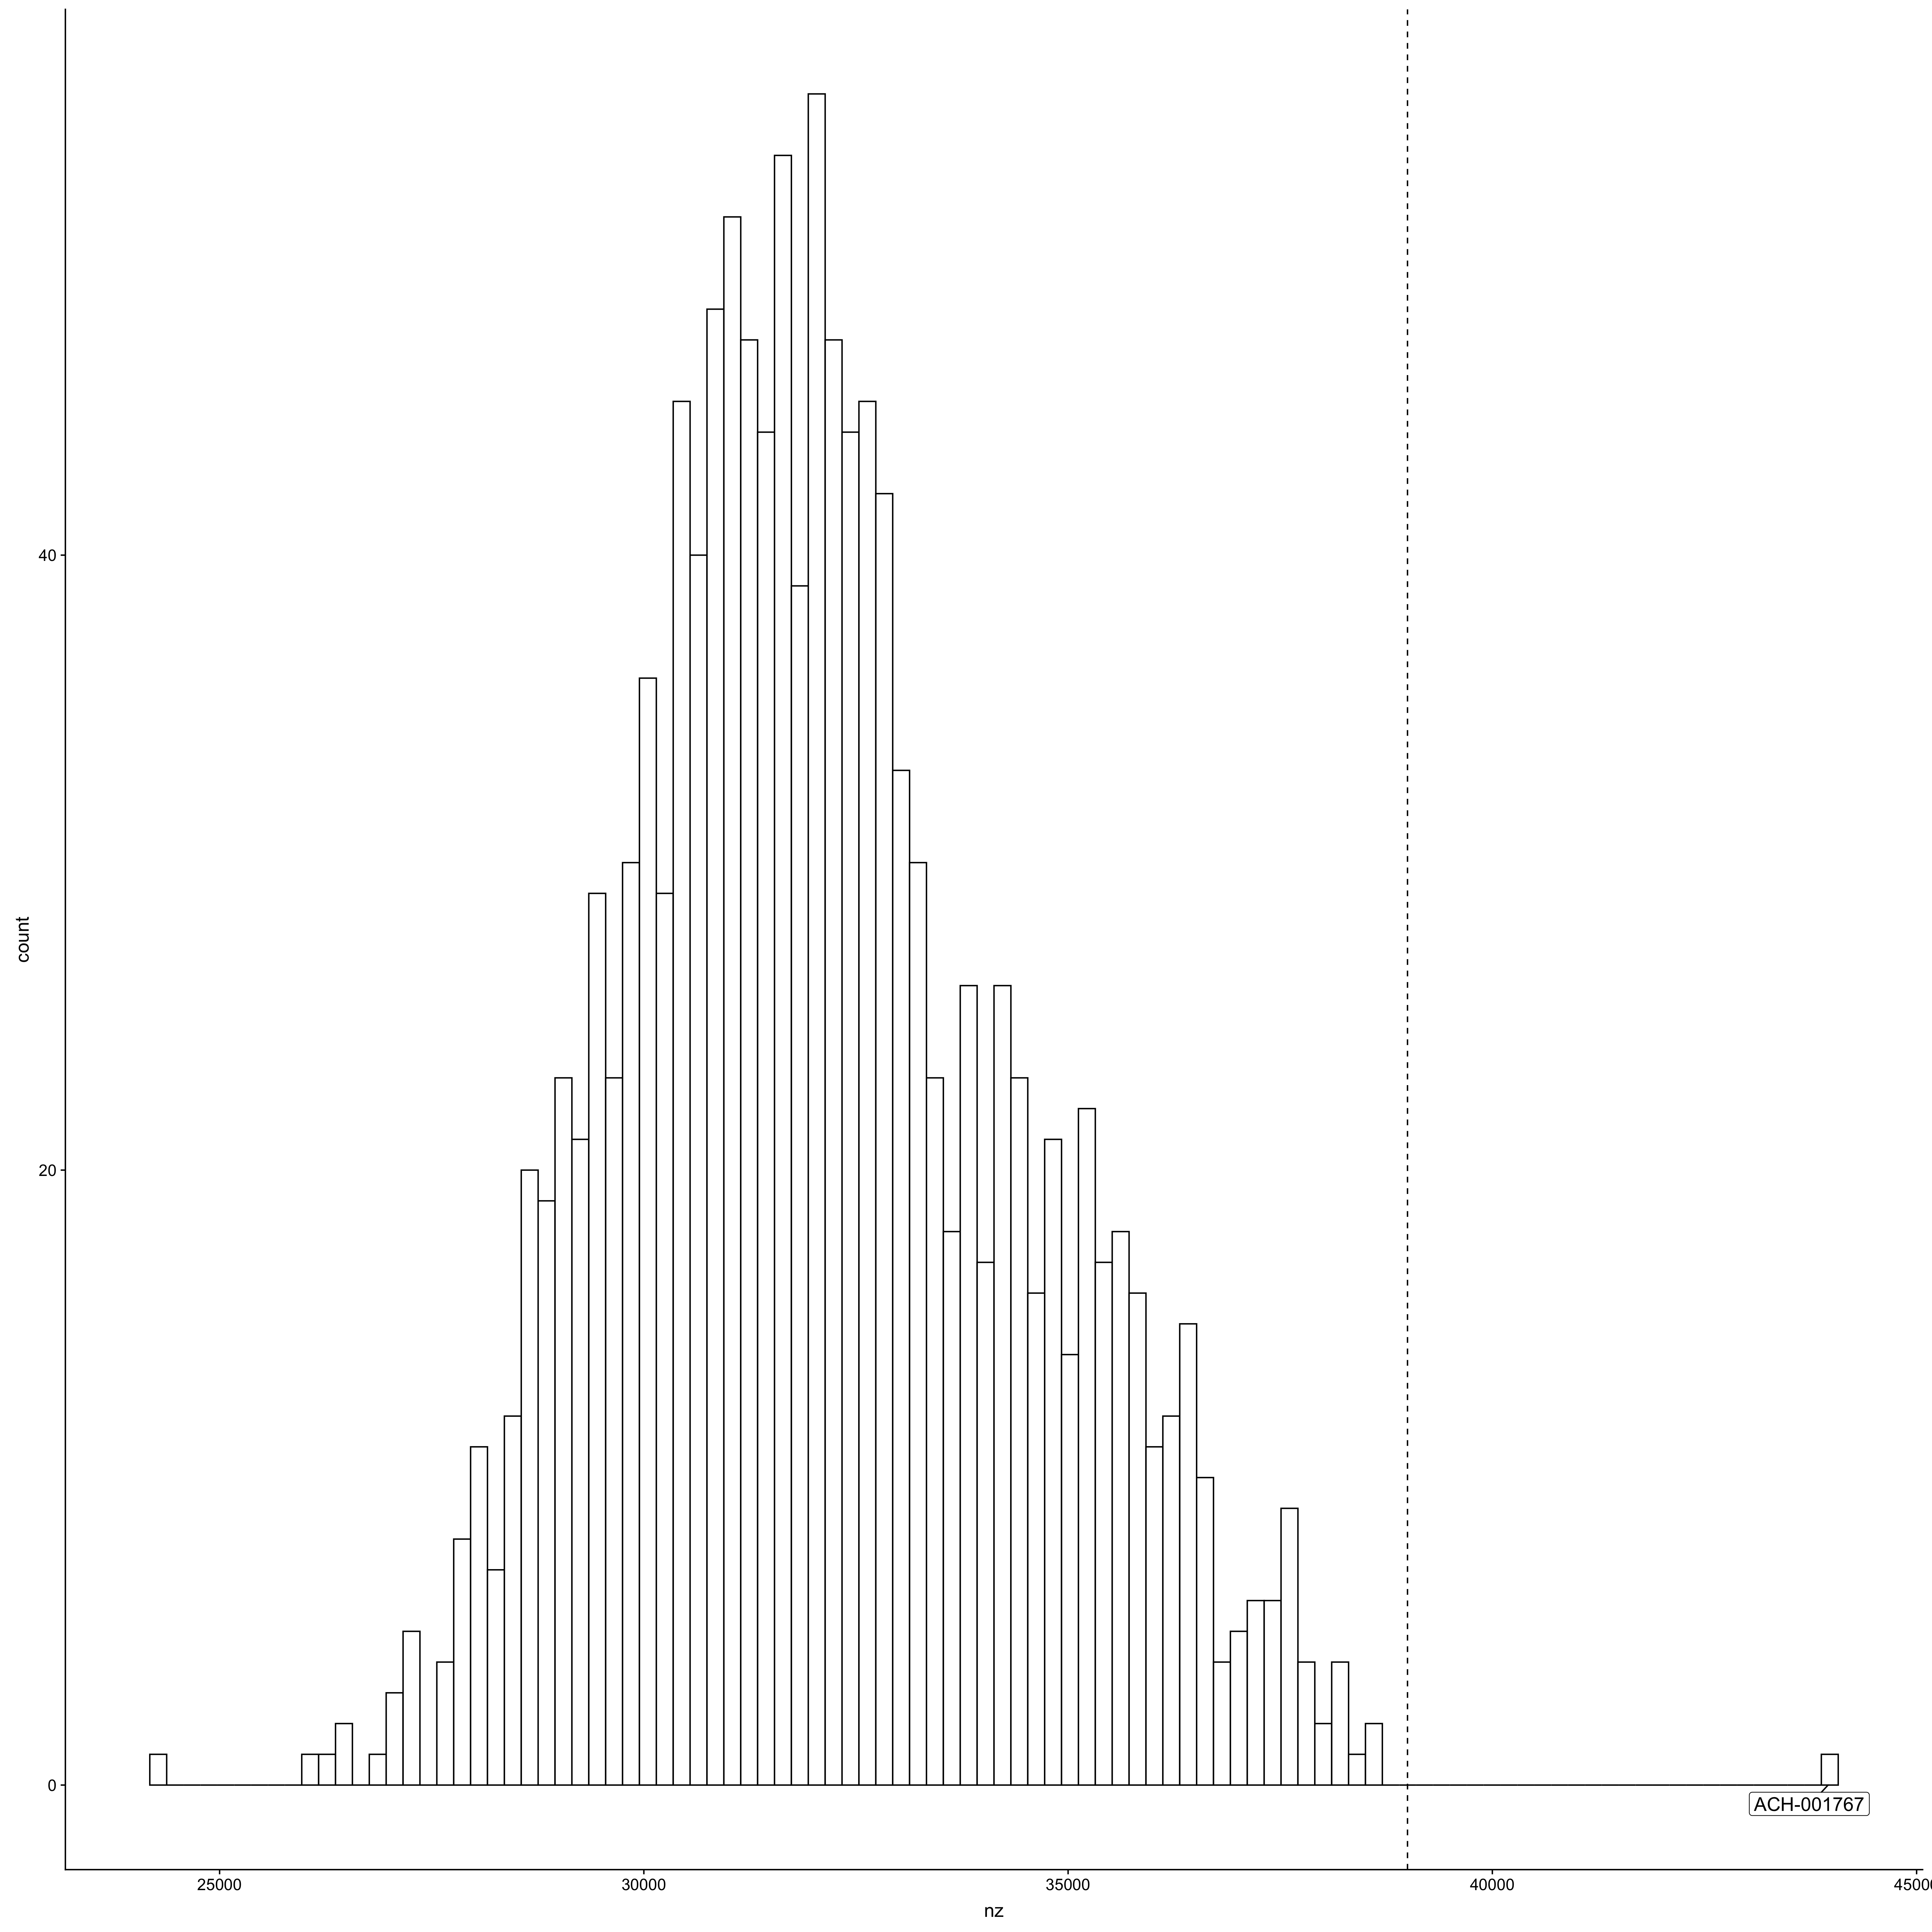

In [15]:
display(Image(filename='temp/ggplot.png'))

In [16]:
%%R
write.table(
  counts_genes, 
  file = paste0('temp/expression.', release,'.counts.tsv'), 
  sep = '\t', row.names = F, quote = F)
write.table(
  tpm_genes, 
  file = paste0('temp/expression.', release,'genes.tsv'), 
  sep = '\t', row.names = F, quote = F)
write.table(
  tpm_transcripts, 
  file = paste0('temp/expression.', release,'.transcripts.tsv'),
  sep = '\t', row.names = F, quote = F)

# Validation

In [55]:
counts_genes = pd.read_csv('temp/expression.'+ release + '.counts.tsv', sep='\t')

In [56]:
tpm_genes = pd.read_csv('temp/expression.'+ release + '.tpm.tsv', sep='\t')
tpm_transcripts = pd.read_csv('temp/expression.'+ release + '.transcripts.tsv', sep='\t')

In [58]:
DM19Q2counts = tc.get(name='depmap-expression-87f8', version=7, file='DM19Q2.counts')
DM19Q2tpm = tc.get(name='depmap-expression-87f8', version=7, file='DM19Q2.tpm')
DM19Q2transcripts = tc.get(name='depmap-expression-87f8', version=7, file='DM19Q2.transcripts')

Taiga needs to convert data before we can fetch it.  Waiting...

Status: Downloading from S3
Status: Running conversion
Status: Uploading converted file to S3


[##################]100% |   2.4 MiB/s |   1.1 GiB /   1.1 GiB | Time:  0:08:01


In [67]:
tpm_genes['ACH-000309'] = DM19Q2tpm['ACH-000309']
tpm_genes['ACH-001852'] = DM19Q2tpm['ACH-001852']
tpm_transcripts['ACH-001852'] = DM19Q2transcripts['ACH-001852']
tpm_transcripts['ACH-000309'] = DM19Q2transcripts['ACH-000309']
counts_genes['ACH-000309'] = DM19Q2counts['ACH-000309']
counts_genes['ACH-001852'] = DM19Q2counts['ACH-001852']

In [68]:
tpm_genes.to_csv('temp/expression.'+ release + '.genes.tsv', sep='\t')
tpm_transcripts.to_csv('temp/expression.'+ release + '.transcripts.tsv', sep='\t')
counts_genes.to_csv('temp/expression.'+ release + '.counts.tsv', sep='\t')

In [15]:
counts_genes.columns.str.contains('ibm')

array([False, False, False, ..., False, False, False])

In [16]:
prev = tc.get(name='depmap-expression-87f8', version=7, file='DM19Q2.tpm')

In [21]:
tpm_genes[tpm_genes.columns[2:]] = tpm_genes[tpm_genes.columns[2:]].apply(lambda x: np.log2(x+1))

In [23]:
new1 = set(counts_genes.columns.values.tolist())
prev = set(prev.columns.values.tolist())

In [24]:
new3 = set(tpm_transcripts.columns.values.tolist())
new2 = set(tpm_genes.columns.values.tolist())

In [25]:
print(len(prev), len(prev & new2), len(new1), len(new1 & new2 & new3), new2-prev, prev-new2)

1290 1288 1299 1298 {'ACH-001802', 'ACH-001690', 'ACH-001442', 'ACH-001525', 'ACH-001347', 'ACH-001636', 'ACH-001670', 'ACH-002018', 'ACH-001617', 'ACH-001616', 'ACH-001862'} {'ACH-001852', 'ACH-000309'}


In [28]:
metadata = tc.get(name='internal-19q2-9504', version=24, file='sample_info')

KeyError: 'type'

In [27]:
metadata

NameError: name 'metadata' is not defined

In [130]:
# finding train and test set
trainame = [val for val in new1&prev if val[:3] == 'ACH']
testname = [val for val in new1-prev if val[:3] == 'ACH']

#looking at the 2000 most variable genes in the two sets
genetolookfor = 2000
gene_var = counts_genes[trainame].var(1).values
print(len(gene_var))
sorting = np.argsort(gene_var)[-genetolookfor:]

58813


In [131]:
unregistered = set(testname) - set(metadata["DepMap_ID"].values.tolist())
unregistered

set()

In [132]:
len(counts_genes['ACH-001767']) - np.count_nonzero(counts_genes['ACH-001767'].values)

KeyError: 'ACH-001767'

In [133]:
# creating and reodering train and test sets
traindata = counts_genes[set(trainame)-unregistered].values[sorting].T
trainlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(trainame)-unregistered].columns.tolist() if val not in unregistered]

testdata = counts_genes[set(testname)-unregistered].values[sorting].T
testlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(testname)-unregistered].columns.tolist() if val not in unregistered]

In [134]:
traindata.shape

(1286, 2000)

In [135]:
# learn KNN classifier to the metadata diseases
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(traindata, trainlabels) 
predicted = neigh.predict(testdata)

In [136]:
predicted[1]

'leukemia'

1 ACH-001616 leukemia lymphoma
2 ACH-001670 bone peripheral_nervous_system
3 ACH-001802 bone soft_tissue
4 ACH-001617 leukemia lymphoma
6 ACH-001442 upper_aerodigestive cervix
7 ACH-001862 ovary bile_duct
8 ACH-001525 breast cervix
10 ACH-002018 skin eye


In [94]:
labels = trainlabels + testlabels
colors=[0]*len(trainlabels)
colors.extend([1,2,2,2,2,1,2,2,2,1,2])
data = np.vstack([traindata,testdata])

In [106]:
# plot them with TSNE, highlight the points that failed and show colors for diseases
dimred = TSNE(2,10).fit_transform(data)

In [108]:
scatter(dimred, labels=labels,colors=colors, radi=1.9)

## Save files for taiga

In [23]:
tc.update_dataset(dataset_permaname="depmap-expression-87f8",
                 upload_file_path_dict={'temp/expression.'+release+'.transcripts.tsv': 'TableTSV',
                                       'temp/expression.'+release+'.genes.tsv': 'TableTSV',
                                       'temp/expression.'+release+'.counts.tsv': 'TableTSV'},
                 dataset_description="# Updating to "+release+"""
                 adding missing samples in Terra merge files
                 
                 
                 """)

Uploading expression.19Q3.transcripts...
hitting https://cds.team/taiga/api/datafile/58baa278db594681af596bf0b125321c
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: expression.19Q3.transcripts properly converted and uploaded
Uploading expression.19Q3.genes...
hitting https://cds.team/taiga/api/datafile/58baa278db594681af596bf0b125321c
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3

	 Done: expression.19Q3.genes properly converted and uploaded
Uploading expression.19Q3.counts...
hitting https://cds.team/taiga/api/datafile/58baa278db594681af596bf0b125321c
Conversion and upload...:


	 Uploading to S3

	 Done: expression.19Q3.counts properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id 8e779795638a4e118f16da203bae6d2a created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/8e779795638a4e118f16da203bae6d2a


'8e779795638a4e118f16da203bae6d2a'

## Fusion post processing

In [ ]:
terra.wait_for_submission(submission_id2)

In [59]:
aggregate = refwm.get_config('Aggregate_Fusion_Calls')
aggregate

{'deleted': False,
 'inputs': {'aggregate_set_files_workflow.aggregate_set_files.disk_space': '250',
  'aggregate_set_files_workflow.aggregate_set_files.output_file_name': '"Fusions.aggregated.tsv"',
  'aggregate_set_files_workflow.aggregate_set_files.aggregate_files_script': 'workspace.aggregate_fusions_script',
  'aggregate_set_files_workflow.aggregate_set_files.num_preempt': '5',
  'aggregate_set_files_workflow.aggregate_set_files.sample_files': 'this.samples.fusion_predictions_abridged',
  'aggregate_set_files_workflow.aggregate_set_files.memory': '3'},
 'methodConfigVersion': 7,
 'methodRepoMethod': {'methodName': 'Aggregate_files_set',
  'methodVersion': 2,
  'methodNamespace': 'gkugener',
  'methodUri': 'agora://gkugener/Aggregate_files_set/2',
  'sourceRepo': 'agora'},
 'name': 'Aggregate_Fusion_Calls',
 'namespace': 'gkugener',
 'outputs': {'aggregate_set_files_workflow.aggregate_set_files.output_merged_file': 'this.fusions_star'},
 'prerequisites': {},
 'rootEntityType': 'sam

In [60]:
refwm.update_config(aggregate)
submission_id2 = refwm.create_submission(aggregate['name'], 'All_samples')

Successfully updated configuration gkugener/Aggregate_Fusion_Calls
Successfully created submission c853b79b-c226-4b29-a718-5875b7f74e10.


In [ ]:
terra.wait_for_submission(submission_id2)

In [10]:
refwm.get_sample_sets().loc['All_samples']['fusions_star']

fusions_star                                                                     NaN
mergedExonUsageRObj_hg38                                                         NaN
rsem_genes_expected_count                                                        NaN
rsem_genes_tpm                                                                   NaN
rsem_transcripts_expected_count                                                  NaN
rsem_transcripts_isopct                                                          NaN
rsem_transcripts_tpm                                                             NaN
samples                            [dm_ACH-000001, dm_ACH-000002, dm_ACH-000003, ...
Name: all_samples, dtype: object

In [37]:
! gsutil cp $aggregated "temp/expression.fusion.tsv"

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/15ab70c1-73af-44bc-9aeb-750ef6d70bc8/aggregate_set_files_workflow/7d6bdfe1-27fb-478b-ade1-fcda622c4960/call-aggregate_set_files/Fusions.aggregated.tsv...
/ [1 files][ 30.2 KiB/ 30.2 KiB]                                                
Operation completed over 1 objects/30.2 KiB.                                     


### Overview

This document contains the code used to generate the unfiltered and filtered versions of the fusion datasets for the release. The bottom of the document also contains some comparisons between the release fusion dataset, CCLE2 fusion calls, and the translocation data from CCLE2.

In [52]:
%%R
source('../JKBio/gkugener/RScripts/load_libraries_and_annotations.R')
source("CCLE_postp_function.R")
filepath <- 'temp/expression.fusion.tsv'
release <- '19Q3'

## Generate filtered fusion table

Release: `r release`

We want to apply filters to the fusion table to reduce the number of artifacts in the dataset. Specifically, we filter the following:

* Remove fusions involving mitochondrial chromosomes, or HLA genes, or immunoglobulin genes
* Remove red herring fusions (from STAR-Fusion annotations column)
* Remove recurrent in CCLE (>= 25 samples)
* Remove fusion with (SpliceType=" INCL_NON_REF_SPLICE" and LargeAnchorSupport="No" and FFPM < 0.1)
* Remove fusions with FFPM < 0.05 (STAR-Fusion suggests using 0.1, but looking at the translocation data, this looks like it might be too aggressive)

In [53]:
%%R
unfiltered_fusions <- readFusions(filepath)
filtered_fusions <- filterFusions(unfiltered_fusions)

In [54]:
%%R
# Save the files (to be uploaded to taiga)
write.table(
  unfiltered_fusions,
  file = paste0('temp/fusions.',release, '.unfiltered.tsv'),
  sep = '\t', quote = F, row.names = F
)
write.table(
  filtered_fusions,
  file = paste0('temp/fusions.', release, '.filtered.tsv'),
  sep = '\t', quote = F, row.names = F
)

# Validation

## Validation Protocol:

to validate fusions, one should be able to list all cells with known fusions (i.e. elwing sarcoma) and check for each new cell in this set of knownfusioncells, if the fusion is present or not. and validate the fusion quality this way.

In [81]:
# check that all cells lines are present on fusion unfiltered
df = pd.read_csv('temp/fusions.'+release+'.unfiltered.tsv', sep='\t')
new = set([i.split('_')[1][:10] for i in list(set(df["DepMap_ID"].tolist()))])
print(prev - new, new-prev)

{'gene_id', 'transcript_id(s)'} {'ACH-001616'}


In [80]:
# remove fusions from the same samples as for that failed expression threshold


{'gene_id', 'transcript_id(s)'}

In [3]:
unfiltered = pd.read_csv('temp/fusions.'+release+'.unfiltered.tsv', sep='\t')
filtered = pd.read_csv('temp/fusions.'+ release+ '.filtered.tsv',sep='\t')

In [8]:
unfiltered["DepMap_ID"] = ['ACH' + i.split('_ACH')[1].split('.')[0] for i in unfiltered["DepMap_ID"]]

In [10]:
filtered["DepMap_ID"] = ['ACH' + i.split('_ACH')[1].split('.')[0] for i in filtered["DepMap_ID"]]

In [12]:
q1filtered = tc.get(name='depmap-fusions-7990', version=1, file='fusions.19q1.filtered')
q1unfiltered = tc.get(name='depmap-fusions-7990', version=1, file='fusions.19q1.unfiltered')

[##################]100% |   5.2 MiB/s |   4.5 MiB /   4.5 MiB | Time:  0:00:00
[##################]100% |   3.8 MiB/s |  98.4 MiB /  98.4 MiB | Time:  0:00:25


In [16]:
filtered

,DepMap_ID,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,CCLE_count
0,ACH-000001,MBP--LINC01899,142,129,ONLY_REF_SPLICE,MBP^ENSG00000197971.14,chr18:77066298:-,LINC01899^ENSG00000265352.1,chr18:71732847:-,YES_LDAS,3.4188,GT,1.9656,AG,1.9656,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr18:5.19...",2
1,ACH-000001,FCHSD2--FAM168A,54,27,ONLY_REF_SPLICE,FCHSD2^ENSG00000137478.14,chr11:72887470:-,FAM168A^ENSG00000054965.10,chr11:73468492:-,YES_LDAS,1.0218,GT,1.8892,AG,1.8323,"[""CCLE_StarF2019"",""ChimerSeq"",""TCGA_StarF2019""...",2
2,ACH-000001,CCDC6--ANK3,44,36,ONLY_REF_SPLICE,CCDC6^ENSG00000108091.10,chr10:59906122:-,ANK3^ENSG00000151150.21,chr10:60139087:-,YES_LDAS,1.0093,GT,1.8892,AG,1.7819,"[""TCGA_StarF2019"",""YOSHIHARA_TCGA"",""TumorFusio...",2
3,ACH-000001,EWSR1--ZNRF3,36,29,ONLY_REF_SPLICE,EWSR1^ENSG00000182944.17,chr22:29273864:+,ZNRF3^ENSG00000183579.15,chr22:28987076:+,YES_LDAS,0.8201,GT,1.8295,AG,1.8892,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr22:0.21...",2
4,ACH-000001,STARD10--FCHSD2,38,18,ONLY_REF_SPLICE,STARD10^ENSG00000214530.9,chr11:72780975:-,FCHSD2^ENSG00000137478.14,chr11:72902638:-,YES_LDAS,0.7065,GT,1.8892,AG,1.8892,"[""Klijn_CellLines"",""CCLE_StarF2019"",""INTRACHRO...",2
5,ACH-000001,SLC38A1--COL2A1,34,15,ONLY_REF_SPLICE,SLC38A1^ENSG00000111371.15,chr12:46229153:-,COL2A1^ENSG00000139219.18,chr12:47980062:-,YES_LDAS,0.6181,GT,1.4566,AG,1.8892,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr12:1.70...",2
6,ACH-000001,ITSN2--OTOF,20,16,ONLY_REF_SPLICE,ITSN2^ENSG00000198399.14,chr2:24328052:-,OTOF^ENSG00000115155.17,chr2:26516599:-,YES_LDAS,0.4542,GT,1.9656,AG,1.9086,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr2:2.10M...",2
7,ACH-000001,SVIL--MPP7,16,28,ONLY_REF_SPLICE,SVIL^ENSG00000197321.14,chr10:29657969:-,MPP7^ENSG00000150054.18,chr10:28089841:-,YES_LDAS,0.5551,GT,1.9329,AG,1.7819,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr10:1.12...",2
8,ACH-000001,LRMDA--ADK,19,13,ONLY_REF_SPLICE,LRMDA^ENSG00000148655.14,chr10:75438494:+,ADK^ENSG00000156110.13,chr10:74708321:+,YES_LDAS,0.4037,GT,1.8892,AG,1.7968,"[""CCLE_StarF2019"",""TCGA_StarF2019"",""INTRACHROM...",3
9,ACH-000001,FBXO34--CDKN3,12,19,ONLY_REF_SPLICE,FBXO34^ENSG00000178974.9,chr14:55271537:+,CDKN3^ENSG00000100526.19,chr14:54399894:+,YES_LDAS,0.3911,GT,1.3710,AG,1.7819,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr14:0.85...",2


In [15]:
q1filtered

,DepMap_ID,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,LargeAnchorSupport,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,FFPM,annots
0,ACH-000001,SLC25A44--DAP3,182,136,ONLY_REF_SPLICE,SLC25A44^ENSG00000160785.9,chr1:156164038:+,DAP3^ENSG00000132676.11,chr1:155679564:+,YES_LDAS,GT,1.8892,AG,1.9329,4.0118,"SLC25A44->solute_carrier_family_25_member_44,D..."
1,ACH-000001,MBP--RP11-723G8.2,82,129,ONLY_REF_SPLICE,MBP^ENSG00000197971.10,chr18:74778254:-,RP11-723G8.2^ENSG00000265352.1,chr18:69400083:-,YES_LDAS,GT,1.9656,AG,1.9656,2.6619,"MBP->myelin_basic_protein,INTRACHROMOSOMAL[chr..."
2,ACH-000001,FCHSD2--FAM168A,48,27,ONLY_REF_SPLICE,FCHSD2^ENSG00000137478.10,chr11:72598515:-,FAM168A^ENSG00000054965.6,chr11:73179537:-,YES_LDAS,GT,1.8892,AG,1.8323,0.9462,"FCHSD2->FCH_and_double_SH3_domains_2,FAM168A->..."
3,ACH-000001,CCDC6--ANK3,45,36,ONLY_REF_SPLICE,CCDC6^ENSG00000108091.10,chr10:61665880:-,ANK3^ENSG00000151150.16,chr10:61898845:-,YES_LDAS,GT,1.8892,AG,1.7819,1.0219,"CCDC6->coiled-coil_domain_containing_6,ANK3->a..."
4,ACH-000001,STARD10--FCHSD2,43,18,ONLY_REF_SPLICE,STARD10^ENSG00000214530.3,chr11:72492020:-,FCHSD2^ENSG00000137478.10,chr11:72613683:-,YES_LDAS,GT,1.8892,AG,1.8892,0.7696,STARD10->StAR_related_lipid_transfer_domain_co...
5,ACH-000001,SLC38A1--COL2A1,33,15,ONLY_REF_SPLICE,SLC38A1^ENSG00000111371.11,chr12:46622936:-,COL2A1^ENSG00000139219.13,chr12:48373845:-,YES_LDAS,GT,1.4566,AG,1.8892,0.6055,"SLC38A1->solute_carrier_family_38_member_1,COL..."
6,ACH-000001,SVIL--MPP7,20,28,ONLY_REF_SPLICE,SVIL^ENSG00000197321.10,chr10:29946898:-,MPP7^ENSG00000150054.14,chr10:28378770:-,YES_LDAS,GT,1.9329,AG,1.7819,0.6055,"SVIL->supervillin,MPP7->membrane_palmitoylated..."
7,ACH-000001,EWSR1--ZNRF3,19,24,ONLY_REF_SPLICE,EWSR1^ENSG00000182944.13,chr22:29669853:+,ZNRF3^ENSG00000183579.11,chr22:29383064:+,YES_LDAS,GT,1.8295,AG,1.8892,0.5425,"EWSR1->EWS_RNA_binding_protein_1,ZNRF3->zinc_a..."
8,ACH-000001,ITSN2--OTOF,19,16,ONLY_REF_SPLICE,ITSN2^ENSG00000198399.10,chr2:24550921:-,OTOF^ENSG00000115155.12,chr2:26739467:-,YES_LDAS,GT,1.9656,AG,1.9086,0.4416,"ITSN2->intersectin_2,OTOF->otoferlin,INTRACHRO..."
9,ACH-000001,TSC2--MAPK8IP3,19,0,INCL_NON_REF_SPLICE,TSC2^ENSG00000103197.12,chr16:2098072:+,MAPK8IP3^ENSG00000138834.8,chr16:1809953:+,YES_LDAS,GG,1.7232,TG,1.9329,0.2397,"TSC2->ArcherDX_panel,FoundationOne_panel,tuber..."


In [20]:
filtered = pd.concat([filtered,q1filtered[q1filtered['DepMap_ID']=='ACH-000309']], sort=False)
unfiltered = pd.concat([unfiltered,q1unfiltered[q1unfiltered['DepMap_ID']=='ACH-000309']], sort=False)

In [21]:
unfiltered.to_csv('temp/fusions.'+release+'.unfiltered.tsv', sep='\t')
filtered.to_csv('temp/fusions.'+ release+ '.filtered.tsv',sep='\t')

# Uploading to Taiga

In [22]:
tc.update_dataset(dataset_permaname="depmap-fusions-7990",
                     upload_file_path_dict={'temp/fusions.'+release+'.filtered.tsv': 'TableTSV',
                                        'temp/fusions.'+release+'.unfiltered.tsv': 'TableTSV'},
                 dataset_description="# Updating to "+release+"""
                 
                 reparing the missing cell lines from Terra
                 """)

Uploading fusions.19Q3.filtered...
hitting https://cds.team/taiga/api/datafile/96df81a7f2d9427298a9cb207a75f93b
Conversion and upload...:

	 Done: fusions.19Q3.filtered properly converted and uploaded
Uploading fusions.19Q3.unfiltered...
hitting https://cds.team/taiga/api/datafile/96df81a7f2d9427298a9cb207a75f93b
Conversion and upload...:
	 Uploading to S3

	 Done: fusions.19Q3.unfiltered properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id e9f2464e3fa24cee81a17e8c407a6898 created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/e9f2464e3fa24cee81a17e8c407a6898


'e9f2464e3fa24cee81a17e8c407a6898'

# IF want to merge here instead of on Terra:

In [39]:
newsamples

NameError: name 'newsamples' is not defined

In [48]:
prevsamplesets = ['CCLE_19Q3interim',samplesetname]
samples = []
for i in prevsamplesets:
    samples.extend(refwm.get_sample_sets().loc[i].samples)
res = []
terrasamp = refwm.get_samples()
for i, sample in enumerate(samples):
    res.append(terrasamp.loc[sample])
    genes_fusion = res[i]['fusion_predictions_abridged']
    rsem_genes_transcripts = res[i]['rsem_isoforms']
    rsem_genes_expected_count = res[i]['rsem_genes']
    ! gsutil cp $rsem_genes_expected_count 'temp/' && gsutil cp $rsem_genes_transcripts 'temp/' && gsutil cp $genes_fusion 'temp/'

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/25b86d44-d5d3-481a-9c29-5438c9905f44/rsem_workflow/7b23b231-27f3-47c4-b3bb-8df48393b187/call-rsem/ibm_ACH-001616.rsem.genes.results...
- [1 files][  6.3 MiB/  6.3 MiB]                                                
Operation completed over 1 objects/6.3 MiB.                                      
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/25b86d44-d5d3-481a-9c29-5438c9905f44/rsem_workflow/7b23b231-27f3-47c4-b3bb-8df48393b187/call-rsem/ibm_ACH-001616.rsem.isoforms.results...
/ [1 files][ 13.6 MiB/ 13.6 MiB]                                                
Operation completed over 1 objects/13.6 MiB.                                     
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/988fb43c-f90d-4327-ba52-be47db7d5f46/trinity_cleaned/9570c783-9757-4a32-a569-b98d02b8a7d6/call-StarFusion/attempt-2/ibm_ACH-001616.star-fusion.fusion_predictions.abridged.tsv...
/ [1 files][ 23.3 KiB/ 23.3 KiB]           

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/39a4b936-8772-49ce-93f8-482b4d18b0bd/rsem_workflow/256b7988-14b3-42ff-b179-4c2b2125785c/call-rsem/ibm_ACH-002018.rsem.isoforms.results...
| [1 files][ 13.6 MiB/ 13.6 MiB]                                                
Operation completed over 1 objects/13.6 MiB.                                     
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/82f53a64-3dc3-40bd-af81-def43059b7a0/trinity_cleaned/c5c749b5-f0ca-4e85-95fa-5356187d6ec8/call-StarFusion/ibm_ACH-002018.star-fusion.fusion_predictions.abridged.tsv...
/ [1 files][ 10.4 KiB/ 10.4 KiB]                                                
Operation completed over 1 objects/10.4 KiB.                                     
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/39a4b936-8772-49ce-93f8-482b4d18b0bd/rsem_workflow/660c2ff0-cd28-4659-bd3b-b826e244f337/call-rsem/ibm_ACH-001636.rsem.genes.results...
- [1 files][  6.3 MiB/  6.3 MiB]                     

In [50]:
mainres = refwm.get_sample_sets().loc['DM19Q2_PATHS_CORRECTED_V2']
maingenes_fusion = mainres['fusions_star']
mainrsem_genes_tpm = mainres['rsem_genes_tpm']
mainrsem_genes_transcripts = mainres['rsem_transcripts_tpm']
mainrsem_genes_expected_count = mainres['rsem_genes_expected_count']
! gsutil cp $mainrsem_genes_expected_count "temp/" && gsutil cp $mainrsem_genes_transcripts "temp/" && gsutil cp $maingenes_fusion "temp/expression.fusion.tsv" && gsutil cp $mainrsem_genes_tpm "temp/"

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/3a120a00-cc0e-4e61-81f0-2efb6f39a40f/rsem_aggregate_results_workflow/7bb43c84-bedb-402a-bdfa-c1e20cba11e5/call-rsem_aggregate_results/DM19Q2_PATHS_CORRECTED_V2.rsem_genes_expected_count.txt.gz...
Resuming download for temp/DM19Q2_PATHS_CORRECTED_V2.rsem_genes_expected_count.txt.gz
- [1 files][ 68.2 MiB/ 68.2 MiB]                                                
Operation completed over 1 objects/68.2 MiB.                                     
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/3a120a00-cc0e-4e61-81f0-2efb6f39a40f/rsem_aggregate_results_workflow/7bb43c84-bedb-402a-bdfa-c1e20cba11e5/call-rsem_aggregate_results/DM19Q2_PATHS_CORRECTED_V2.rsem_transcripts_tpm.txt.gz...
| [1 files][228.9 MiB/228.9 MiB]    8.9 MiB/s                                   
Operation completed over 1 objects/228.9 MiB.                                    
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/7ab5a444-1b66-41ea-b1

In [54]:
mainres['rsem_genes_expected_count']

'gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/3a120a00-cc0e-4e61-81f0-2efb6f39a40f/rsem_aggregate_results_workflow/7bb43c84-bedb-402a-bdfa-c1e20cba11e5/call-rsem_aggregate_results/DM19Q2_PATHS_CORRECTED_V2.rsem_genes_expected_count.txt.gz'

In [51]:
addSamplesRSEMToMain(res,mainres)

[autoreload of wand._api failed: Traceback (most recent call last):
  File "/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/anaconda3/envs/py36/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/envs/py36/lib/python3.6/importlib/__init__.py", line 147, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module wand.api not in sys.modules
]


In [52]:
genes_fusion = ['temp/'+val['fusion_predictions_abridged'].split('/')[-1] for val in res]
addToMainFusion(genes_fusion,'temp/expression.fusion.tsv')

> /Users/jeremie/Documents/Projects/BroadInstitute/ccle_processing/CCLE_postp_function.py(152)addToMainFusion()
-> maindata = pd.read_csv(main_filename, sep='\t')
(Pdb) c
